# 0. TMDB Box Office Prediction

- [TMDB Box Office Prediction](https://www.kaggle.com/competitions/tmdb-box-office-prediction)


## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

## 파일 로드

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [9]:
base_path = "/gdrive/My Drive/Colab Notebooks/data/tmdb"

train = pd.read_csv(f"{base_path}/train.csv", index_col="id")
test = pd.read_csv(f"{base_path}/test.csv", index_col="id")
submission = pd.read_csv(f"{base_path}/sample_submission.csv", index_col="id")

train.shape, test.shape, submission.shape

((3000, 22), (4398, 21), (4398, 1))

# 1. EDA & Feature Engineering

In [10]:
# nunique (범주형 OR 수치형)
print(train.nunique())

belongs_to_collection     422
budget                    406
genres                    872
homepage                  941
imdb_id                  3000
original_language          36
original_title           2975
overview                 2992
popularity               2999
poster_path              2999
production_companies     2383
production_countries      321
release_date             2398
runtime                   139
spoken_languages          401
status                      2
tagline                  2400
title                    2969
Keywords                 2648
cast                     2975
crew                     2984
revenue                  2850
dtype: int64


In [11]:
# 결측치
print(train.isnull().sum())

belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64


In [12]:
train.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


## collection 

In [14]:
train['has_collection'] = 0
train.loc[train["belongs_to_collection"].isnull() == False , 'has_collection'] = 1

test['has_collection'] = 0
test.loc[test['belongs_to_collection'].isnull() == False, 'has_collection'] = 1

## budget

In [15]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

## homepage

In [16]:
train['has_homepage'] = 0
train.loc[train["homepage"].isnull() == False , 'has_homepage'] = 1

test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

## 장르
5번째 장르까지 표시할 예정

### train

In [17]:
def make_genres(order, index):
    order_gen = []
    
    for i in tqdm(range(3000)):
        try:
            a = "".join(train["genres"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_gen.append(a)
    return order_gen

In [18]:
train["first_genres"] = make_genres("first", 1)
train["second_genres"] = make_genres("second", 3)
train["third_genres"] = make_genres("third", 5)

100%|██████████| 3000/3000 [00:10<00:00, 295.08it/s]


In [19]:
train[["genres", "first_genres", "second_genres", "third_genres"]].sample(5)

,genres,first_genres,second_genres,third_genres
id,,,,
1851,"[{'id': 35, 'name': 'Comedy'}]",Action,Romance,Comedy
1566,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Drama,Crime,0
2746,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Drama,Comedy,Crime
2106,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Comedy,0,0
2439,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Drama,0,0


머신러닝 적용을 위해 장르명(문자형)을 장르코드(숫자)로 바꿔줌

In [20]:
print("순서별 장르의 nunique 값")
print(train["first_genres"].nunique(), train["second_genres"].nunique(), train["third_genres"].nunique())
      
print("=" * 30)
      
print("second:", set(train["first_genres"]) - set(train["second_genres"]))
print("third:", set(train["first_genres"]) - set(train["third_genres"]))

순서별 장르의 nunique 값
21 20 20
second: {'TV Movie'}
third: {'TV Movie'}


In [23]:
train["first_genres"].unique()

genres_code = {0:0, 'Comedy':1, 'Drama':2, 'Thriller':3, 'Action':4, 
               'Animation':5, 'Horror':6, 'Documentary':7, 'Adventure':8, 
               'Crime':9, 'Mystery':10, 'Fantasy':11, 'War':12,
               'Science Fiction':13, 'Romance':14, 'Music':15, 'Western':16, 
               'Family':17, 'History':18, 'Foreign':19, 'TV Movie':20}

In [24]:
train["first_genres_code"] = train["first_genres"].apply(lambda x : genres_code[x])
train["second_genres_code"] = train["second_genres"].apply(lambda x : genres_code[x])
train["third_genres_code"] = train["third_genres"].apply(lambda x : genres_code[x])

### test

In [25]:
def make_genres(order, index):
    order_gen = []
    
    for i in tqdm(range(4398)):
        try:
            a = "".join(test["genres"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_gen.append(a)
    return order_gen

In [26]:
test["first_genres"] = make_genres("first", 1)
test["second_genres"] = make_genres("second", 3)
test["third_genres"] = make_genres("third", 5)

100%|██████████| 4398/4398 [00:23<00:00, 187.66it/s]


In [28]:
print("순서별 장르의 nunique 값")
print(test["first_genres"].nunique(), test["second_genres"].nunique(), test["third_genres"].nunique())

print("=" * 30)
print("second:", set(test["first_genres"]) - set(test["second_genres"]))
print("third:", set(test["first_genres"]) - set(test["third_genres"]))

순서별 장르의 nunique 값
20 20 19
second: set()
third: {'Documentary'}


train에서 하드코딩한 값을 test에도 적용하여 장르명을 장르코드로 만들어준다.

In [29]:
test["first_genres_code"] = test["first_genres"].apply(lambda x : genres_code[x])
test["second_genres_code"] = test["second_genres"].apply(lambda x : genres_code[x])
test["third_genres_code"] = test["third_genres"].apply(lambda x : genres_code[x])

### 사용하지 않을 컬럼 삭제

In [30]:
train = train.drop(columns = ["genres", "first_genres", "second_genres", "third_genres"])
test = test.drop(columns = ["genres", "first_genres", "second_genres", "third_genres"])

train.shape, test.shape, set(train) - set(test)

((3000, 27), (4398, 26), {'revenue'})

## original language

희소한값에 대해서는 기타 처리

In [31]:
train["original_language"].value_counts().nsmallest(40)

id       1
ur       1
el       1
ar       1
nb       1
he       1
mr       1
cs       1
sr       1
vi       1
bn       1
fi       2
te       2
pl       2
ml       2
no       2
hu       3
tr       3
ro       4
fa       5
da       5
pt       6
nl       6
sv       8
ta      16
de      18
zh      19
cn      20
ko      20
it      24
ja      37
hi      42
es      43
ru      47
fr      78
en    2575
Name: original_language, dtype: int64

특정 수치 이하인 것은 기타로 묶어주겠다.

In [32]:
original_language_count = train["original_language"].value_counts()
original_language_under = original_language_count[original_language_count >= 47].index.to_list()
print(original_language_under)

['en', 'fr', 'ru']


### train

In [33]:
train["original_language_etc"] = train["original_language"]
train.loc[~train["original_language"].isin(original_language_under), "original_language_etc"] = "etc"

train[["original_language", "original_language_etc"]]
train["original_language_etc"].value_counts(), train["original_language_etc"].nunique()

(en     2575
 etc     300
 fr       78
 ru       47
 Name: original_language_etc, dtype: int64,
 4)

### test

In [34]:
test["original_language_etc"] = test["original_language"]
test.loc[~test["original_language"].isin(original_language_under), "original_language_etc"] = "etc"

test[["original_language", "original_language_etc"]]
test["original_language_etc"].value_counts(), test["original_language_etc"].nunique()

(en     3776
 etc     439
 fr      121
 ru       62
 Name: original_language_etc, dtype: int64,
 4)

### 사용하지 않을 컬럼 삭제 

In [35]:
train = train.drop(columns = "original_language")
test = test.drop(columns = "original_language")
train.shape, test.shape

((3000, 27), (4398, 26))

## popularity

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64


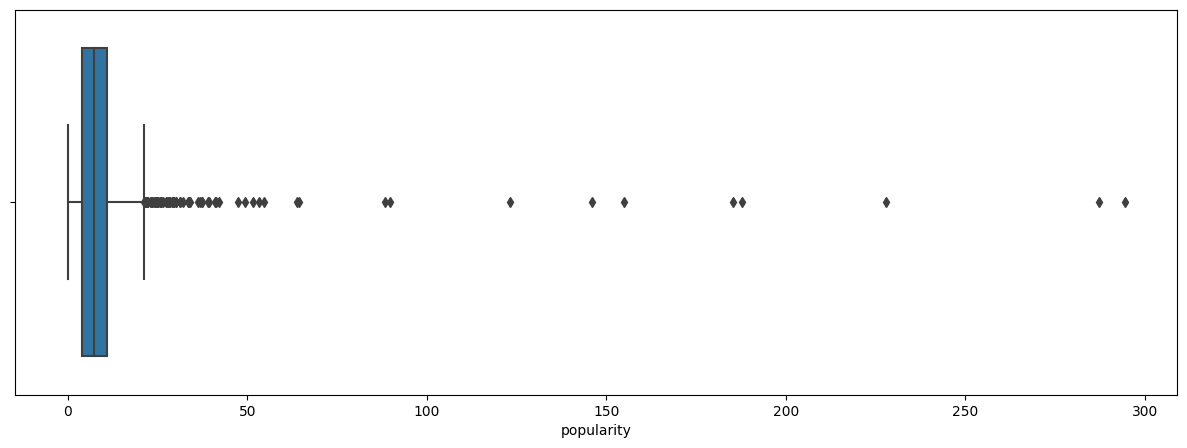

In [37]:
print(train["popularity"].describe())

plt.figure(figsize = (15,5))
sns.boxplot(data = train, x = "popularity");

In [38]:
per_25 = train["popularity"].describe()[4]
per_75 = train["popularity"].describe()[6]

### train

In [39]:
train.loc[train["popularity"] < per_25, "popularity_class"] = "low"
train.loc[train["popularity"] > per_75, "popularity_class"] = "high"
train["popularity_class"].fillna("median", inplace = True)
train["popularity_class"].value_counts()

median    1500
high       750
low        750
Name: popularity_class, dtype: int64

### test

In [40]:
test.loc[test["popularity"] < per_25, "popularity_class"] = "low"
test.loc[test["popularity"] > per_75, "popularity_class"] = "high"
test["popularity_class"].fillna("median", inplace = True)
test["popularity_class"].value_counts()

median    2152
low       1133
high      1113
Name: popularity_class, dtype: int64

### 사용하지 않을 컬럼 삭제

In [41]:
train = train.drop(columns = "popularity")
test = test.drop(columns = "popularity")
train.shape, test.shape

((3000, 27), (4398, 26))

## production_companies
2번째 회사까지 표시할 예정

### train

In [42]:
def make_company(order, index):
    order_company = []
    
    for i in tqdm(range(3000)):
        try:
            a = "".join(train["production_companies"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_company.append(a)
    return order_company

In [43]:
train["first_company"] = make_company("first", 0)
train["second_company"] = make_company("second", 2)

100%|██████████| 3000/3000 [00:11<00:00, 261.58it/s]


### test

In [44]:
def make_company(order, index):
    order_company = []
    
    for i in tqdm(range(4398)):
        try:
            a = "".join(test["production_companies"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_company.append(a)
    return order_company

In [45]:
test["first_company"] = make_company("first", 0)
test["second_company"] = make_company("second", 2)

100%|██████████| 4398/4398 [00:23<00:00, 185.64it/s]


### 소형, 중대형으로 분류하기

- 4 이하이면 소형, 4초과이면 중대형
- train의 first_comapny 빈도수 기준

In [46]:
first_company_count = train["first_company"].value_counts()
first_company_under = first_company_count[first_company_count > 4].index.to_list()
print(first_company_under)

['Universal Pictures', 'Paramount Pictures', 0, 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'Warner Bros.', 'New Line Cinema', 'Walt Disney Pictures', 'Columbia Pictures Corporation', 'TriStar Pictures', 'United Artists', 'Metro-Goldwyn-Mayer (MGM)', 'Miramax Films', 'Fox Searchlight Pictures', 'Village Roadshow Pictures', 'Touchstone Pictures', 'BBC Films', 'Orion Pictures', 'Hollywood Pictures', 'Summit Entertainment', 'DreamWorks SKG', 'Lionsgate', 'StudioCanal', 'Imagine Entertainment', 'Fox 2000 Pictures', 'Regency Enterprises', 'Lions Gate Films', 'Lakeshore Entertainment', 'The Weinstein Company', 'France 2 Cinéma', 'Dune Entertainment', 'Legendary Pictures', 'Cannon Group', 'Castle Rock Entertainment', 'Eon Productions', 'Gaumont', 'WingNut Films', 'Dimension Films', 'American Zoetrope', 'Universal Studios', 'Original Film', 'Lucasfilm', 'Silver Pictures', 'Studio Babelsberg', 'Alcon Entertainment', 'Fine Line Features', 'Screen Gems', 'Channel Four Films', '

In [47]:
train["first_company_class"] = "중대형"
train.loc[~train["first_company"].isin(first_company_under), "first_company_class"] = "소형"

train["second_company_class"] = "중대형"
train.loc[~train["second_company"].isin(first_company_under), "second_company_class"] = "소형"

test["first_company_class"] = "중대형"
test.loc[~test["first_company"].isin(first_company_under), "first_company_class"] = "소형"

test["second_company_class"] = "중대형"
test.loc[~test["second_company"].isin(first_company_under), "second_company_class"] = "소형"

### 사용하지 않을 컬럼 삭제

In [48]:
train = train.drop(columns = ["first_company","second_company","production_companies"])
test = test.drop(columns = ["first_company","second_company","production_companies"])
train.shape, test.shape

((3000, 28), (4398, 27))

## production_countries

첫번째 국가만 표시할 예정

### train

In [49]:
def make_country(order, index):
    order_country = []
    
    for i in tqdm(range(3000)):
        try:
            a = "".join(train["production_countries"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_country.append(a)
    return order_country

In [50]:
train["production_country"]= make_country("first", 0)

100%|██████████| 3000/3000 [00:10<00:00, 280.80it/s]


### test

In [51]:
def make_country(order, index):
    order_country = []
    
    for i in tqdm(range(4398)):
        try:
            a = "".join(test["production_countries"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_country.append(a)
    return order_country

In [52]:
test["production_country"]= make_country("first", 0)

100%|██████████| 4398/4398 [00:22<00:00, 194.17it/s]


### 국가 희소값 처리

['US', 'GB']


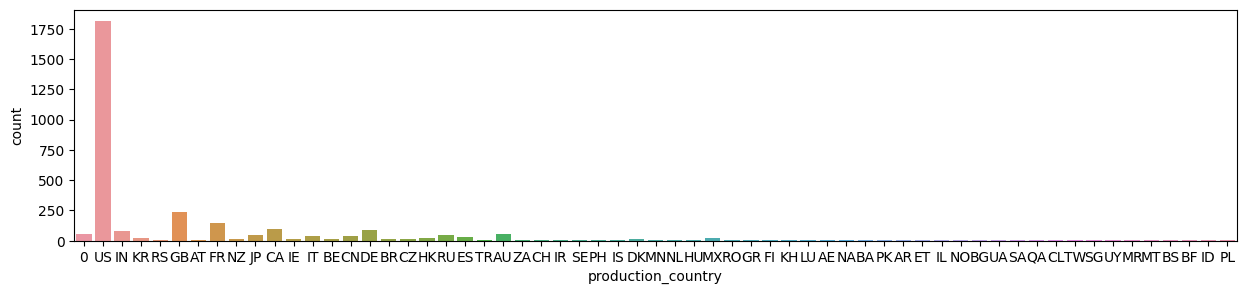

In [53]:
plt.figure(figsize = (15,3))
sns.countplot(data = train, x = "production_country");

production_country_count = train["production_country"].value_counts()
production_country_under = production_country_count[production_country_count >= 150].index.to_list()
print(production_country_under)

In [54]:
production_country_count.nlargest(60)

US    1817
GB     234
FR     147
CA      97
DE      90
IN      78
0       56
AU      52
JP      50
RU      47
IT      36
CN      34
ES      33
HK      20
MX      19
KR      19
IE      17
BE      14
NZ      13
BR      12
DK      11
CZ      10
SE       8
HU       6
NL       6
AT       6
GR       5
AE       5
FI       4
RO       4
IR       4
NO       3
CL       3
ZA       3
CH       2
TR       2
KH       2
LU       2
BS       2
PH       2
UA       2
AR       2
BG       2
IL       2
BF       1
SG       1
MT       1
UY       1
MR       1
ID       1
TW       1
MN       1
QA       1
SA       1
ET       1
PK       1
BA       1
NA       1
IS       1
RS       1
Name: production_country, dtype: int64

In [55]:
train["production_country_etc"] = train["production_country"]
train.loc[~train["production_country"].isin(production_country_under), "production_country_etc"] = "etc"

train[["production_country", "production_country_etc"]]
train["production_country_etc"].value_counts()
train["production_country_etc"].nunique()

test["production_country_etc"] = test["production_country"]
test.loc[~test["production_country"].isin(production_country_under), "production_country_etc"] = "etc"

test[["production_country", "production_country_etc"]]
test["production_country_etc"].value_counts()
test["production_country_etc"].nunique()

3

### 사용하지 않을 컬럼 삭제 

In [56]:
train = train.drop(columns = ["production_countries", "production_country"])
test = test.drop(columns = ["production_countries", "production_country"])
train.shape, test.shape

((3000, 28), (4398, 27))

## release_date

In [57]:
train["release_date"] = train["release_date"].fillna(0)
test["release_date"] = test["release_date"].fillna(0)

### train 

In [58]:
train["release_date"] = pd.to_datetime(train["release_date"])

train["개봉연도"] = train["release_date"].dt.year
train["개봉월"] = train["release_date"].dt.month
train["개봉일"] = train["release_date"].dt.day
train["개봉요일"] = train["release_date"].dt.dayofweek

### test 

In [59]:
test["release_date"] = pd.to_datetime(test["release_date"])

test["개봉연도"] = test["release_date"].dt.year
test["개봉월"] = test["release_date"].dt.month
test["개봉일"] = test["release_date"].dt.day
test["개봉요일"] = test["release_date"].dt.dayofweek

In [60]:
train = train.drop(columns = ["release_date"])
test = test.drop(columns = ["release_date"])

train.shape, test.shape

((3000, 31), (4398, 30))

## runtime

In [61]:
train["runtime"].describe()

count    2998.000000
mean      107.856571
std        22.086434
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

In [62]:
per_25 = train["runtime"].describe()[4]
per_75 = train["runtime"].describe()[6]

In [63]:
train.loc[train["runtime"] < per_25, "runtime_class"] = "low"
train.loc[train["runtime"] > per_75, "runtime_class"] = "high"
train["runtime_class"].fillna("median", inplace = True)
train["runtime_class"].value_counts()

median    1565
high       737
low        698
Name: runtime_class, dtype: int64

In [64]:
test.loc[test["runtime"] < per_25, "runtime_class"] = "low"
test.loc[test["runtime"] > per_75, "runtime_class"] = "high"
test["runtime_class"].fillna("median", inplace = True)
test["runtime_class"].value_counts()

median    2328
high      1038
low       1032
Name: runtime_class, dtype: int64

In [65]:
train = train.drop(columns = ["runtime"])
test = test.drop(columns = ["runtime"])

train.shape, test.shape

((3000, 31), (4398, 30))

## spoken_languages

### train

In [66]:
num = []
for i in tqdm(range(3000)):
    try:
        a = int(len(train["spoken_languages"].str.split(",")[i])/2)
    except:
        a = 0
    num.append(a)

100%|██████████| 3000/3000 [00:11<00:00, 270.64it/s]


In [67]:
train["spoken_languages_num"] = num

### test

In [68]:
num = []
for i in tqdm(range(4398)):
    try:
        a = int(len(test["spoken_languages"].str.split(",")[i])/2)
    except:
        a = 0
    num.append(a)

100%|██████████| 4398/4398 [00:21<00:00, 202.51it/s]


In [69]:
test["spoken_languages_num"] = num

## keywords 

In [70]:
num = []
for i in tqdm(range(3000)):
    try:
        a = int(len(train["Keywords"].str.split(",")[i])/2)
    except:
        a = 0
    num.append(a)

100%|██████████| 3000/3000 [00:19<00:00, 156.62it/s]


In [71]:
train["keywords_num"] = num

In [72]:
num = []
for i in tqdm(range(4398)):
    try:
        a = int(len(test["Keywords"].str.split(",")[i])/2)
    except:
        a = 0
    num.append(a)

100%|██████████| 4398/4398 [00:41<00:00, 104.94it/s]


In [73]:
test["keywords_num"] = num

## cast

In [74]:
num = []
for i in tqdm(range(3000)):
    try:
        a = int(len(train["cast"].str.split(",")[i])/8)
    except:
        a = 0
    num.append(a)

100%|██████████| 3000/3000 [04:15<00:00, 11.73it/s]


In [75]:
train["cast_num"] = num

In [76]:
num = []
for i in tqdm(range(4398)):
    try:
        a = int(len(test["cast"].str.split(",")[i])/8)
    except:
        a = 0
    num.append(a)

100%|██████████| 4398/4398 [09:25<00:00,  7.78it/s]


In [77]:
test["cast_num"] = num

## crew

In [78]:
num = []
for i in tqdm(range(3000)):
    try:
        a = int(len(train["crew"].str.split(",")[i])/7)
    except:
        a = 0
    num.append(a)

100%|██████████| 3000/3000 [03:54<00:00, 12.77it/s]


In [79]:
train["crew_num"] = num

In [80]:
num = []
for i in tqdm(range(4398)):
    try:
        a = int(len(test["crew"].str.split(",")[i])/7)
    except:
        a = 0
    num.append(a)

100%|██████████| 4398/4398 [09:09<00:00,  8.01it/s]


In [81]:
test["crew_num"] = num

# 2. 데이터셋

In [82]:
train.columns

Index(['belongs_to_collection', 'budget', 'homepage', 'imdb_id',
       'original_title', 'overview', 'poster_path', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'has_collection', 'log_budget', 'has_homepage', 'first_genres_code',
       'second_genres_code', 'third_genres_code', 'original_language_etc',
       'popularity_class', 'first_company_class', 'second_company_class',
       'production_country_etc', '개봉연도', '개봉월', '개봉일', '개봉요일', 'runtime_class',
       'spoken_languages_num', 'keywords_num', 'cast_num', 'crew_num'],
      dtype='object')

In [84]:
train = train.drop(columns = ['belongs_to_collection','homepage', 'imdb_id', 
                              'original_title', 'overview', 'poster_path', 'spoken_languages', 
                              'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', "개봉일"])

test = test.drop(columns = ['belongs_to_collection', 'homepage', 'imdb_id', 
                              'original_title', 'overview', 'poster_path', 'spoken_languages', 
                              'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', "개봉일"])

In [85]:
train.shape, test.shape

((3000, 21), (4398, 20))

In [86]:
display(train)
display(test)
print(set(train) - set(test))

,budget,revenue,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,original_language_etc,popularity_class,...,second_company_class,production_country_etc,개봉연도,개봉월,개봉요일,runtime_class,spoken_languages_num,keywords_num,cast_num,crew_num
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,12314651,1,16.454568,0,0,0,0,en,median,...,중대형,etc,2015,2,4,low,0,0,0,0
2,40000000,95149435,1,17.504390,0,1,0,0,en,median,...,중대형,US,2004,8,4,median,1,4,24,72
3,3300000,13092000,0,15.009433,1,1,2,17,en,high,...,중대형,US,2014,10,4,median,1,4,20,9
4,1200000,16000000,0,13.997833,1,2,0,0,etc,low,...,중대형,US,2012,3,4,high,1,12,51,64
5,0,3923970,0,0.000000,0,3,2,0,etc,low,...,중대형,etc,2009,2,3,median,2,7,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0,1596687,0,0.000000,0,2,0,0,en,median,...,중대형,US,1994,4,4,median,1,2,7,17
2997,0,180590,0,0.000000,0,1,14,0,etc,low,...,소형,US,2013,3,3,median,1,19,15,17
2998,65000000,89456761,0,17.989898,0,2,15,0,en,high,...,소형,etc,1996,10,4,high,1,6,11,15


,budget,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,original_language_etc,popularity_class,first_company_class,second_company_class,production_country_etc,개봉연도,개봉월,개봉요일,runtime_class,spoken_languages_num,keywords_num,cast_num,crew_num
id,,,,,,,,,,,,,,,,,,,,
3001,0,1,0.000000,1,0,0,0,etc,low,중대형,중대형,etc,2007,7,5,low,0,0,0,0
3002,88000,0,11.385103,0,0,0,0,en,low,중대형,중대형,etc,2058,5,6,low,0,0,0,0
3003,0,0,0.000000,0,0,0,0,en,median,중대형,중대형,etc,1997,5,4,median,0,0,0,0
3004,6800000,0,15.732433,1,0,0,0,fr,median,중대형,중대형,etc,2010,9,5,high,0,0,0,0
3005,2000000,0,14.508658,0,0,0,0,en,low,중대형,중대형,etc,2005,2,4,low,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7394,42000000,0,17.553180,0,4,8,12,en,median,중대형,소형,GB,2001,8,4,median,5,17,54,28
7395,19000000,1,16.759950,0,2,3,0,en,median,중대형,소형,US,2004,8,4,median,3,7,9,49
7396,16000000,0,16.588099,0,1,0,0,en,median,중대형,중대형,US,1982,12,2,high,1,7,20,21


{'revenue'}


## one-hot-encoding

In [87]:
train = pd.get_dummies(data = train)
test = pd.get_dummies(data = test)

train.shape, test.shape

((3000, 32), (4398, 31))

In [88]:
display(train.head())
display(test.head())
print(set(train) - set(test))

,budget,revenue,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,개봉연도,개봉월,...,first_company_class_소형,first_company_class_중대형,second_company_class_소형,second_company_class_중대형,production_country_etc_GB,production_country_etc_US,production_country_etc_etc,runtime_class_high,runtime_class_low,runtime_class_median
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,12314651,1,16.454568,0,0,0,0,2015,2,...,0,1,0,1,0,0,1,0,1,0
2,40000000,95149435,1,17.504390,0,1,0,0,2004,8,...,0,1,0,1,0,1,0,0,0,1
3,3300000,13092000,0,15.009433,1,1,2,17,2014,10,...,0,1,0,1,0,1,0,0,0,1
4,1200000,16000000,0,13.997833,1,2,0,0,2012,3,...,1,0,0,1,0,1,0,1,0,0
5,0,3923970,0,0.000000,0,3,2,0,2009,2,...,0,1,0,1,0,0,1,0,0,1


,budget,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,개봉연도,개봉월,개봉요일,...,first_company_class_소형,first_company_class_중대형,second_company_class_소형,second_company_class_중대형,production_country_etc_GB,production_country_etc_US,production_country_etc_etc,runtime_class_high,runtime_class_low,runtime_class_median
id,,,,,,,,,,,,,,,,,,,,,
3001,0,1,0.000000,1,0,0,0,2007,7,5,...,0,1,0,1,0,0,1,0,1,0
3002,88000,0,11.385103,0,0,0,0,2058,5,6,...,0,1,0,1,0,0,1,0,1,0
3003,0,0,0.000000,0,0,0,0,1997,5,4,...,0,1,0,1,0,0,1,0,0,1
3004,6800000,0,15.732433,1,0,0,0,2010,9,5,...,0,1,0,1,0,0,1,1,0,0
3005,2000000,0,14.508658,0,0,0,0,2005,2,4,...,0,1,0,1,0,0,1,0,1,0


{'revenue'}


## 정답값, 피쳐값

In [89]:
train.columns

Index(['budget', 'revenue', 'has_collection', 'log_budget', 'has_homepage',
       'first_genres_code', 'second_genres_code', 'third_genres_code', '개봉연도',
       '개봉월', '개봉요일', 'spoken_languages_num', 'keywords_num', 'cast_num',
       'crew_num', 'original_language_etc_en', 'original_language_etc_etc',
       'original_language_etc_fr', 'original_language_etc_ru',
       'popularity_class_high', 'popularity_class_low',
       'popularity_class_median', 'first_company_class_소형',
       'first_company_class_중대형', 'second_company_class_소형',
       'second_company_class_중대형', 'production_country_etc_GB',
       'production_country_etc_US', 'production_country_etc_etc',
       'runtime_class_high', 'runtime_class_low', 'runtime_class_median'],
      dtype='object')

In [90]:
label_name = "revenue"
feature_names = ['budget', 'has_collection', 'log_budget', 'has_homepage',
       'first_genres_code', 'second_genres_code', 'third_genres_code', '개봉연도', '개봉월',
       '개봉요일', 'spoken_languages_num', 'keywords_num', "cast_num", 'crew_num',
       'original_language_etc_en', 'original_language_etc_etc',
       'original_language_etc_fr', 'original_language_etc_ru',
       'popularity_class_high', 'popularity_class_low',
       'popularity_class_median', 'first_company_class_소형',
       'first_company_class_중대형', 'second_company_class_소형',
       'second_company_class_중대형', 'production_country_etc_GB',
       'production_country_etc_US', 'production_country_etc_etc',
       'runtime_class_high', 'runtime_class_low', 'runtime_class_median']

## label - 로그 스케일링

In [91]:
train["revenue"] = np.log(train["revenue"] + 1)

## 학습, 예측 데이터 셋 만들기

In [92]:
X_train = train[feature_names]
print(X_train.shape)

(3000, 31)


In [93]:
X_test = test[feature_names]
print(X_test.shape)

(4398, 31)


In [94]:
y_train = train[label_name]

#3. 머신러닝(catboost)

In [95]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.0 MB/s eta 0:00:00


In [96]:
from catboost import CatBoostRegressor

In [97]:
model = CatBoostRegressor(random_state= 42)
model

In [98]:
# 학습
model.fit(X_train, y_train)

# 예측
y_predict = model.fit(X_train, y_train).predict(X_test)

Learning rate set to 0.048704
0:	learn: 2.9979412	total: 49.4ms	remaining: 49.3s
1:	learn: 2.9422061	total: 52.1ms	remaining: 26s
2:	learn: 2.8891903	total: 54.6ms	remaining: 18.1s
3:	learn: 2.8409747	total: 57.5ms	remaining: 14.3s
4:	learn: 2.7963956	total: 60ms	remaining: 11.9s
5:	learn: 2.7494255	total: 62.6ms	remaining: 10.4s
6:	learn: 2.7089215	total: 65.1ms	remaining: 9.24s
7:	learn: 2.6709754	total: 67.5ms	remaining: 8.37s
8:	learn: 2.6382637	total: 69.9ms	remaining: 7.7s
9:	learn: 2.6052083	total: 72.4ms	remaining: 7.17s
10:	learn: 2.5728770	total: 74.8ms	remaining: 6.72s
11:	learn: 2.5445482	total: 77.2ms	remaining: 6.36s
12:	learn: 2.5200273	total: 79.7ms	remaining: 6.05s
13:	learn: 2.4969371	total: 82.2ms	remaining: 5.79s
14:	learn: 2.4772490	total: 84.5ms	remaining: 5.55s
15:	learn: 2.4533477	total: 87ms	remaining: 5.35s
16:	learn: 2.4351371	total: 89.3ms	remaining: 5.17s
17:	learn: 2.4177021	total: 91.7ms	remaining: 5s
18:	learn: 2.3994101	total: 94ms	remaining: 4.86s
19:	

In [99]:
submission["revenue"] = np.exp(y_predict) - 1
submission

,revenue
id,
3001,4.851731e+06
3002,4.675514e+05
3003,9.321935e+06
3004,7.586908e+06
3005,1.760632e+05
...,...
7394,4.910970e+07
7395,5.629798e+07
7396,4.703805e+07


In [100]:
submission.to_csv("submission.csv")

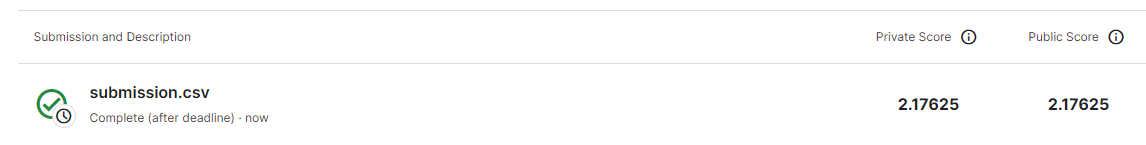